In [0]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U pandas-profiling
import warnings
warnings.filterwarnings('ignore')
!pip install geopandas

In [0]:
ToBeDropped=['availability_30','availability_365',
             'availability_60','availability_90','country',
             'country_code','host_location','host_name','host_picture_url',
             'host_since','maximum_nights','minimum_nights','name','picture_url'
             ,'requires_license','require_guest_profile_picture','require_guest_phone_verification'
             ,'listing_url','listing_url','license','host_thumbnail_url','zipcode','calendar_last_scraped'
             ,'scrape_id','is_location_exact','instant_bookable','has_availability','host_has_profile_pic'
             ,'host_about','house_rules','calculated_host_listings_count','suburb'
             ,'street','summary','transit','state','space','smart_location','notes'
             ,'neighborhood_overview','last_scraped','interaction','description'
             ,'calendar_updated','access','host_url']
import pandas as pd
import pandas_profiling
Listings = pd.read_csv('/content/drive/My Drive/cleansed_listings_dec18.csv')
Listings.drop(labels=ToBeDropped , inplace=True, axis=1)


In [0]:
Listings.profile_report(style={'full_width':True})

Output hidden; open in https://colab.research.google.com to view.

# many simple values should be dropped first since they have no valueable information about the properties or serious effort is needed to make them work


#taking Care of Nans one by one
##Bathrooms

In [0]:
#print(Listings.groupby('bedrooms').bathrooms.mean())
#print(Listings.groupby('bedrooms').bathrooms.std())
#print(Listings.loc[Listings.bathrooms.isna()==True].bedrooms.unique())## only one bedroom listings have nan value
Listings.bathrooms.fillna(value=1,inplace=True)

##Bedrooms


In [0]:
#print(Listings.groupby('bathrooms').bedrooms.mean())
#print(Listings.groupby('bathrooms').bedrooms.std())
#missing value spotted on 2 bathroom places
#print(Listings.loc[Listings.bedrooms.isna()==True].bathrooms.unique())
##
#Listings[Listings.bathrooms==1].bedrooms.fillna(value=1,inplace=True)
#Listings[Listings.bathrooms==2].bedrooms.fillna(value=2,inplace=True)
Listings.loc[(Listings.bathrooms==1)&(Listings.bedrooms.isna()==True),'bedrooms']=1
Listings.loc[(Listings.bathrooms==2)&(Listings.bedrooms.isna()==True),'bedrooms']=2


###Beds

In [0]:

#print(Listings.groupby('bedrooms').beds.mean())
#print(Listings.groupby('bedrooms').beds.std())
#missing value spotted on 2 bathroom places
#print(Listings.loc[Listings.beds.isna()==True].bedrooms.unique())
##
Listings.loc[(Listings.beds.isna()==True)&(Listings.bedrooms==0),'beds']=1
Listings.loc[(Listings.beds.isna()==True)&(Listings.bedrooms==1),'beds']=1
Listings.loc[(Listings.beds.isna()==True)&(Listings.bedrooms==2),'beds']=2
Listings.loc[(Listings.beds.isna()==True)&(Listings.bedrooms==4),'beds']=3


# Can neighbourhood be approximated by geographical features?
Using Neighbourhood.geojason each listing's region was approximated.

In [0]:
#print(Listings.groupby('host_neighborhood').neighborhood.value_counts())
#print(Listings.loc[Listings.neighborhood.isna()==True].host_neighborhood.value_counts())
## lets see if we find a relation ship between host neighbourhood and listing's neibourhood
for i in Listings.dropna().host_neighborhood.unique():
      temp =Listings.loc[Listings.host_neighborhood==i] 
      temp=temp.groupby(['neighborhood'])['host_neighborhood'].value_counts().rename('count').reset_index()
      val =temp.iloc[0]['neighborhood']
      #filling the value
      Listings.loc[(Listings.host_neighborhood==i)
                        &(Listings.neighborhood.isna()==True),'neighbourhood']=val
##

In [0]:

Data=Listings[['longitude','latitude','neighbourhood','price']].copy()
NoLabel=Data.loc[Data.neighbourhood.isna()==True]
Data.dropna(inplace=True)
# using these features
X= Data[['longitude','latitude','price']]
y= Data['neighbourhood']
#df = pd.get_dummies(X['street'])
#X = pd.concat([X, df], axis=1, join='inner')
#X.drop('street',axis=1,inplace=True)

### lets plot the neighbourhoods and see if we can use KNN or not
color and price should be fixed

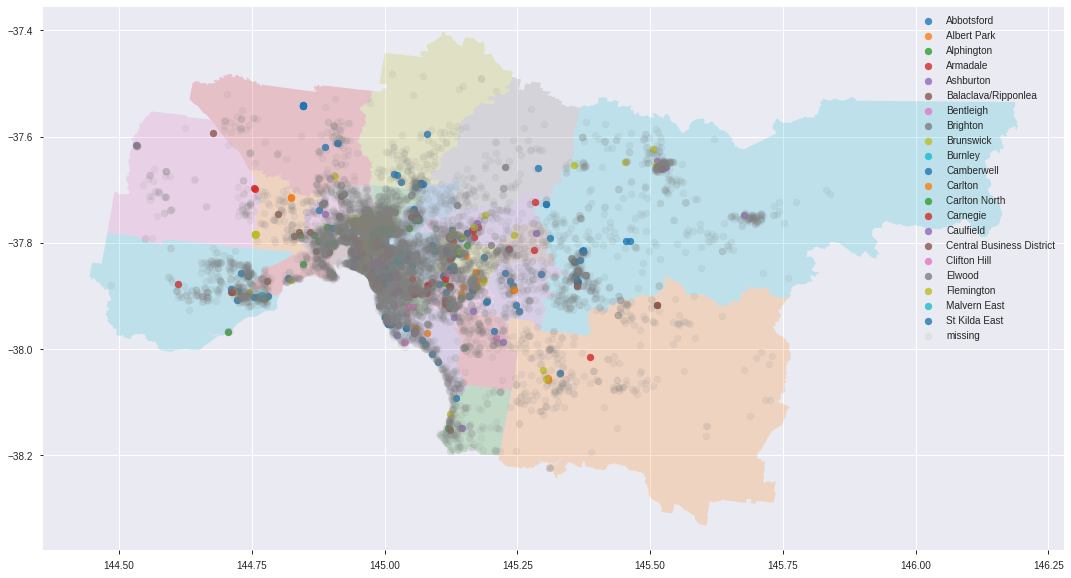

In [0]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
df_places = gpd.read_file('/content/neighbourhoods.geojson')
ax = df_places.plot(column='neighbourhood',alpha=0.21)
scatter_x = Data['longitude'].values
scatter_y = Data['latitude'].values
scatter_s = Data['price'].values
group = Data.neighbourhood.values
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g,alpha=0.8,)
ax.scatter(NoLabel['longitude'],NoLabel['latitude'], label='missing',c='gray',alpha=0.1,)
ax.legend()
ax.figure.set_size_inches(20, 10)
plt.show()

In [0]:
X.isna().sum()
X.shape
Cop = X.copy()

### we make a simple logistic regression model and see how it preforms on our data.

In [0]:
X=Cop.copy()
########----------------------------
def GridSearch(X_train,y_train,mdl,params,cv,sc):
  from sklearn.model_selection import GridSearchCV
  cvg= GridSearchCV(mdl,verbose=1,scoring=Sc,param_grid=params,n_jobs=-1,cv=Cv)
  res=cvg.fit(X_train,y_train)
  return res
#####-----------------------------------
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import Normalizer

X.drop('price',inplace=True,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Cv=5
Sc='f1_macro'
Sc='accuracy'
Sc='f1_weighted'
#### logistic regression -> not good at all, poor accuracy and F1 scroe
from sklearn.linear_model import LogisticRegression
params={'max_iter':np.linspace(100,1500,15)}
mdl= LogisticRegression()
### rando forest tree model and params
"""
from sklearn.ensemble import RandomForestClassifier
mdl =RandomForestClassifier(n_jobs=-1)
params={'n_estimators':[2000]
        ,'max_depth':[4]}
        """
###  
from sklearn.neighbors import KNeighborsClassifier
mdl = KNeighborsClassifier()
params={'n_neighbors':[1,3,5,7,9],
        'p':[1,2],
        'weights' :['uniform','distance'],}
res=GridSearch(X_train,y_train,mdl,params,Cv,Sc)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished


In [0]:
res.best_score_
#res.best_params_

0.7768158325554653

In [0]:
temp= Listings.copy()
import json
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point
nb=Data.neighbourhood.unique()
# load GeoJSON file containing sectors

def func(row):
    point = Point(row['longitude'],row['latitude'])
# check each polygon to see if it contains the point
    for feature in func.js['features']:
      polygon = shape(feature['geometry'])
      name =feature['properties']['neighbourhood']
      if polygon.contains(point):
          return name

with open('neighbourhoods.geojson') as f:
     func.js = json.load(f)


temp['NBR']=temp[['longitude','latitude']].apply(func,axis=1)
temp.head()
Listings['nbr']= temp['NBR']

In [0]:
### missing values so small that they are not significant
Listings.loc[Listings.host_identity_verified.isna()==True,
             'host_identity_verified']='f'
Listings.loc[Listings.host_is_superhost.isna()==True,
             'host_is_superhost']='f'


In [0]:
import pandas as pd
import numpy as np

Listings = pd.read_csv('/content/drive/My Drive/semi_cleaned.csv')
NewDropList=['host_id','host_url','neighborhood','neighbourhood'
             ,'monthly_price'
             ,'weekly_price','host_neighborhood','Unnamed: 0','city'
             ,'first_review'
             ,'last_review']

Listings.drop(NewDropList,axis=1,inplace=True)
Listings.dropna(inplace=True)
Listings.head()


,id,host_response_time,host_response_rate,host_is_superhost,host_verifications,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,nbr
2,12936,within an hour,100%,t,"['email', 'phone', 'google', 'reviews', 'jumio...",t,-37.859755,144.977369,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",159,450.0,100.0,2,28,15,94.0,9.0,10.0,9.0,9.0,9.0,9.0,strict_14_with_grace_period,0.15,Port Phillip
5,38271,within an hour,100%,t,"['email', 'phone', 'manual_online', 'reviews',...",t,-38.057254,145.339356,Apartment,Entire home/apt,5,1.0,3.0,3.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Pool,Kitc...",98,0.0,0.0,1,30,112,97.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.14,Casey
7,43414,within an hour,100%,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,-37.810267,144.985920,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Pool,Kitchen,Gym,Elevator,Heating,Was...",100,1000.0,30.0,1,25,3,93.0,10.0,9.0,9.0,10.0,9.0,9.0,moderate,0.29,Melbourne
8,43429,within an hour,100%,t,"['email', 'phone', 'facebook', 'reviews', 'jum...",f,-37.899601,145.114475,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",98,500.0,40.0,1,0,168,97.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,1.72,Monash
9,44082,within an hour,100%,t,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,-38.149320,145.141569,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",60,0.0,29.0,1,20,28,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,0.29,Frankston


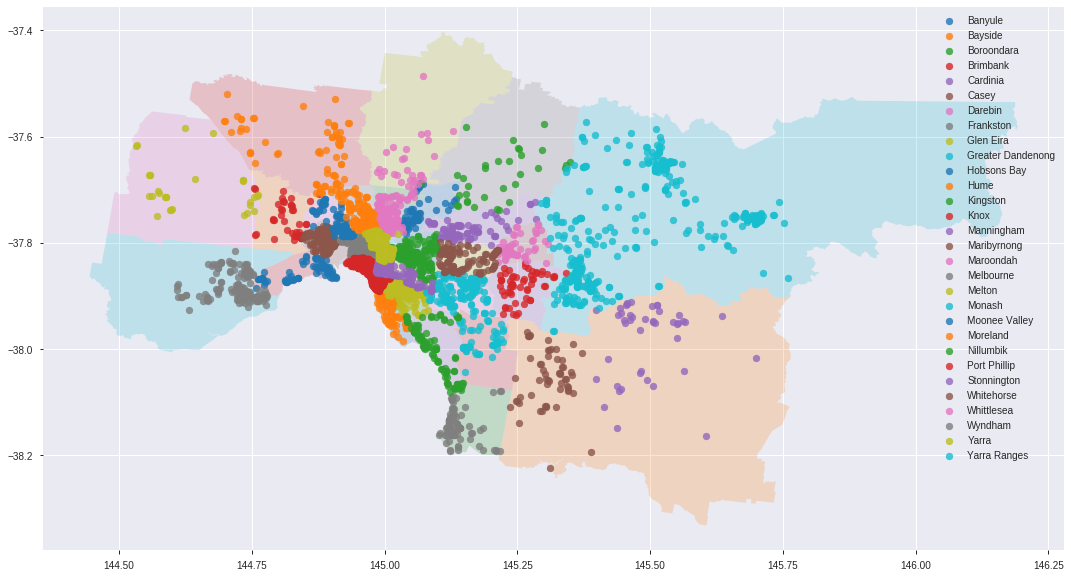

In [0]:
Data= Listings
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
df_places = gpd.read_file('/content/neighbourhoods.geojson')
ax = df_places.plot(column='neighbourhood',alpha=0.21)
scatter_x = Data['longitude'].values
scatter_y = Data['latitude'].values
scatter_s = Data['price'].values
group = Data.nbr.values
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g,alpha=0.8,)
ax.legend()
ax.figure.set_size_inches(20, 10)
plt.show()

In [0]:
def hverify(row):
    return len(row)
def hrt(row):
    return hrt.var[row]
def apart(row):
    return apart.var[row]
def parse(row):
    parsed=row.replace('{',' ').replace('}',' ').split(',')
    return len(parsed)
def fixhiv(row):
    if(row=='t'):
       res=1
    else:
       res=0
    return res     
def fixperc(row):
    res=int(row.replace('%',''))
    return res
Dummy=['bed_type','cancellation_policy','host_response_time'
       ,'property_type','room_type','nbr']
hrtvar=['within an hour', 'within a few hours', 'within a day',
       'a few days or more']
hrtnum=[3,2,1,0]
apartvar=['Entire home/apt', 'Private room', 'Shared room']
apartnum=[2,1,0]
apart.var=dict(zip(apartvar,apartnum))
hrt.var=dict(zip(hrtvar,hrtnum))
Listings['hv']=Listings['host_verifications'].apply(hverify)
Listings['hrt']=Listings['host_response_time'].apply(hrt)
Listings['rt']=Listings['room_type'].apply(apart)
Listings['host_response_rate']=Listings['host_response_rate'].apply(fixperc)
Listings['amenities_num']=Listings['amenities'].apply(parse)
Listings['host_identity_verified']=Listings['host_identity_verified'].apply(fixhiv)
Listings['host_is_superhost']=Listings['host_is_superhost'].apply(fixhiv)
#dummies=pd.get_dummies(Listings,columns=Dummy)
#Listings = pd.concat([Listings, dummies], axis=1, join='inner')
#Listings.head()

Listings.room_type.unique()
Listings.head()
Listings.to_csv('/content/drive/My Drive/Clean.csv')

In [0]:
nums=['host_response_rate', 'host_is_superhost', 'host_identity_verified',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'hv', 'hrt', 'rt',
       'amenities_num', 'res']
textft=['id','name','cancellation_policy','nbr','bed_type',
        'amenities','room_type','property_type',
        'host_verifications','host_response_time',
        'latitude','longitude','normalPrice']

sp=['Federation Square'	,'Royal Botanic Gardens Victoria'
	,'National Sports Museum'	,"Arts Centre Melbourn"	,
  'National Gallery of Victoria'	,'Eureka Skydeck'	,'Royal Arcade'	
 ,'Royal Exhibition Building',	'Melbourne Zoo',	'Shrine of Remembrance',
 	'Parliament House',	'Immigration Museum']
textf = list((textft)+(sp))
ones=[1]*len(nums)
weights=dict(zip(nums,ones))

In [0]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 500)
Listings=pd.read_csv('/content/lstaverageDist.csv')
filters={
    'host_response_time':'within an hour'
        
         }
dist={'ave_dist':80}
amen=['wifi','TV']
price=[0,300]
##------------ fixed
def filter(filters,amen,ds,dist,price):
    if dist != None: 
      for dis in dist:
        ds=ds.loc[ds[dis]<dist[dis]]
    #checking if df is empty
    if ds.shape[0]==0:
      return ds 
    if filters!=None:
      for filts in filters:
        ds=ds.loc[ds[filts]==filters[filts]]
    #checking if df is empty
    if ds.shape[0]==0:
      return ds 
    if amen !=None:
      for elements in amen:
        ds=ds.loc[ds['amenities'].str.contains(elements)]
    if price !=None:
       ds=ds.loc[ds['price']>=price[0]]
       ds=ds.loc[ds['price']<=price[1]]
    return ds
    
#---------------------------------
def Cluster(weights,ds,textft,nclusters):
    #checking if df is empty
    if ds.shape[0]==0:
      return ds 
    
    ss= StandardScaler()
    X= ds.copy()
    X.drop(textft,axis=1,inplace=True) 
    X[:]=ss.fit_transform(X)
    # applying weights
    for label in weights:
        X[label]=weights[label]*X[label]
    #------
    kmeans= KMeans(n_jobs=-1,n_clusters=nclusters,algorithm='full')
    kmeans.fit(X)

    X['labels']=kmeans.predict(X=X)
    print(X.columns)
    ds['labels']=X['labels']
    return ds

def describe(res):
    
    vars=['price','reviews_per_month','amenities_num',
          'review_scores_rating','labels']
    df =pd.DataFrame()
    df = res[vars]
    df=df.groupby('labels').std()
    x=json.loads(json.dumps({'data':[{"x": df.index.tolist(), 
                       "yrev": df['reviews_per_month'].tolist()
                       ,"yamen": df['amenities_num'].tolist()
                       ,"yrs": df['review_scores_rating'].tolist()
                       ,'type':'bar'}]}))
    return x
#--------
amen=None
import json
res=filter(filters,amen,Listings,dist,price)
des=pd.DataFrame()
weights['price']=1
if res.shape[0]!=0:
    #print('clustering')
    Listings=Cluster(weights,res,textft,5)
    des=describe(Listings)
des#des[('host_response_rate', 'count')] this is how elements can be 
# accessed

Index(['host_response_rate', 'host_is_superhost', 'host_identity_verified',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'hv', 'hrt', 'rt',
       'amenities_num', 'res', 'ave_dist', 'labels'],
      dtype='object')


{'data': [{'type': 'bar',
   'x': [0, 1, 2, 3, 4],
   'yamen': [9.958068131773683,
    11.062063551341868,
    9.367366811202054,
    11.838085758514671,
    11.098202942924472],
   'yrev': [1.2912792410706884,
    1.9000864166375453,
    0.6188418569412052,
    1.9326473998606835,
    1.820584282413397],
   'yrs': [8.514751489001728,
    3.411320698386441,
    17.663349128605944,
    4.008452260221842,
    4.1706755733148855]}]}

In [0]:
Listings.to_csv('id.csv')

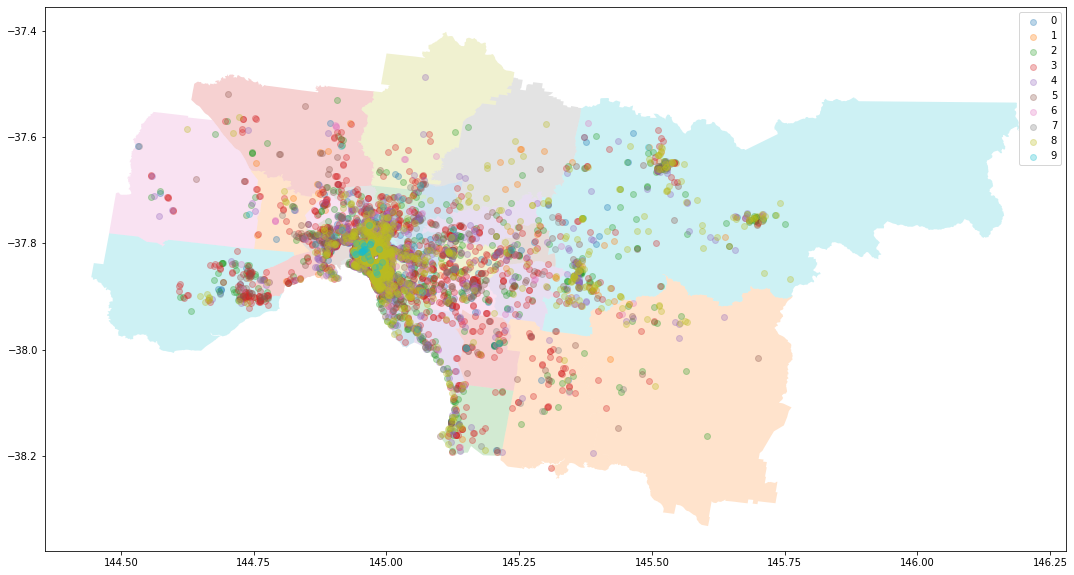

In [0]:
Listings['lables']=res['lables']
Data= Listings
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
df_places = gpd.read_file('/content/neighbourhoods.geojson')
ax = df_places.plot(column='neighbourhood',alpha=0.21)
scatter_x = Data['longitude'].values
scatter_y = Data['latitude'].values
scatter_s = Data['price'].values
group = Data.lables.values
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g,alpha=0.3,)
ax.legend()
ax.figure.set_size_inches(20, 10)
plt.show()

In [0]:
import pandas as pd
from sklearn.cluster import KMeans
k=2
df=pd.read_csv('/content/winequality-red.csv')
label='quality'
kmeans= KMeans(n_jobs=-1,n_clusters=k)
if((label=='quality')):
        df['labels']=kmeans.fit_predict(X=df)
        l=[]
        for i in range(k):
            pf = df.loc[df['labels'] == i]
            pf.drop('labels', axis=1, inplace=True)
            X = pf.corr().copy()
            X.index.name = 'name'
            X['label'] = i
            l.append(X)
        res = pd.concat(l)
res.to_csv()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


'name,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label\nfixed acidity,1.0,-0.03285408410634838,0.4922566327402451,0.09212819619712082,0.20866821849891554,0.0698619377607194,-0.033065472572452514,0.6748953806560257,-0.5300039066359121,0.13056062786948316,-0.21374405163222968,-0.07354809517199384,0\nvolatile acidity,-0.03285408410634838,1.0,-0.34128068381741183,-0.019117841411035993,0.11264424966221609,-0.21073761707095467,0.03254773735467272,0.15513022478804414,0.03274886009529426,-0.0990381479815331,-0.2408915066540083,-0.26425047090139003,0\ncitric acid,0.4922566327402451,-0.34128068381741183,1.0,0.15101837585242137,0.3207684261997357,0.048366738640018656,0.12710667819684665,0.27773323869653055,-0.4023763245669603,0.26219575547934015,-0.029689915238478075,0.018739820738610902,0\nresidual sugar,0.09212819619712082,-0.019117841411035993,0.15101837585242137,1.0,0.07917203381053166,0.309

In [0]:

import pandas as pd
ds=pd.read_csv('/content/Clean.csv')
res=CheckIfIn(ds,144.95,-37.84,0.58)
print(res)
"""(listing.roomType + ' in ' + listing.propType + '<br><b>' + listing.name + '</b><br>'
            + listing.bathroom + ' bathromms.' + listing.bedrooms + ' bedrooms.' + listing.beds + ' beds<br>' + listing.price + 'AU$/Night'+
            '<br/><br/><button type="button" class="btn btn-warning" data-toggle="modal" data-target="#myModal">Analyze Reviews</button>')
"""
print(ds[['longitude','latitude']].head())
print(ds.shape[0])

0.9813658340048348% of listings are inside the domain<br><b>0.01863416599516521%of listings are outside</b><br><button type="button" class="btn btn-warning" data-toggle="modal" data-target="#myModal">Analyze Reviews</button>
    longitude   latitude
0  144.977369 -37.859755
1  145.339356 -38.057254
2  144.985920 -37.810267
3  145.114475 -37.899601
4  145.141569 -38.149320
9928


## fixing sentiment analysis in a one gram manner for word cloud

In [0]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
